In [5]:
"""
ADHD Prediction Dataset - Modelling & Evaluation Module

This notebook implements and evaluates machine learning models for ADHD prediction,
including hyperparameter optimization, model comparison, and final performance assessment.

Author: [Your Name]
Date: [Date]
Project: ADHD Sex Prediction
Input: Final engineered dataset from Feature Engineering module
Output: Optimized models, performance metrics, and deployment-ready artifacts
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import os

# =============================================================================
# CONFIGURATION AND SETTINGS
# =============================================================================

# Set random seed for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.25  # 0.25 of remaining 80% = 20% of total

# Model evaluation settings
CV_FOLDS = 5
SCORING_METRIC = 'f1_macro'
N_JOBS = -1



In [6]:
# =============================================================================
# DATA LOADING AND PREPARATION
# =============================================================================

def load_and_prepare_data():
    """
    Load final engineered dataset and prepare for modeling.
    
    Returns:
    --------
    df : pd.DataFrame
        Loaded dataset ready for modeling.
    """

    
    # Load final dataset
    data_path = r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\balanced_train_data.csv"
    X_train = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\X_train_balanced.pkl")
    y_train = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\y_train_balanced.pkl")
    X_val = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\X_val_processed.pkl")
    y_val = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\y_val.pkl")
    X_test = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\X_test_processed.pkl")
    y_test = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\y_test.pkl")


    print(f"   Training (balanced): {X_train.shape}")
    print(f"   Validation: {X_val.shape}")  
    print(f"   Test: {X_test.shape}")
    print(f"   Target distribution (train): {dict(pd.Series(y_train).value_counts().sort_index())}")
    
    try:
        df = pd.read_csv(data_path)
      
        print(f"   Dataset shape: {df.shape}")
        
       
        
        return df, X_train, y_train, X_val, y_val, X_test, y_test
        
    except Exception as e:
        print(f" Error loading dataset: {str(e)}")
        raise

# Load and prepare data
df, X_train, y_train, X_val, y_val, X_test, y_test = load_and_prepare_data()

   Training (balanced): (815, 756)
   Validation: (200, 756)
   Test: (201, 756)
   Target distribution (train): {0: 408, 1: 407}
   Dataset shape: (815, 757)


In [7]:
# =============================================================================
# LOAD PRE-OPTIMIZED (TUNED) MODELS
# =============================================================================

def load_optimized_models(models_dir=r'C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\tuned_models'):
    """
    Loads models that were already trained and optimized using hyperparameter tuning.

    Parameters:
    -----------
    models_dir : str
        Path to the folder containing the saved tuned models and tuning summary.

    Returns:
    --------
    dict
        A dictionary of models with structure:
        {
            'model_name': {
                'model': trained_model_object,
                'best_params': dict of hyperparameters,
                'cv_f1_score': best cross-validation F1-macro score
            }, ...
        }
    """
    print("Loading pre-optimized models...")
    print("=" * 50)

    summary_path = os.path.join(models_dir, 'tuning_summary.pkl')
    summary = joblib.load(summary_path)

    loaded_models = {}

    for model_name, info in summary.items():
        # Load trained model and its best parameters
        model = joblib.load(info['model_path'])
        best_params = joblib.load(info['params_path'])

        loaded_models[model_name] = {
            'model': model,
            'best_params': best_params,
            'cv_f1_score': info['best_score']
        }

        print(f"Model: {model_name}")
        print(f"  CV F1-Macro: {info['best_score']:.4f}")
        print(f"  Best Parameters: {best_params}")

    return loaded_models


# =============================================================================
# VALIDATION SET EVALUATION
# =============================================================================

def evaluate_all_models_on_validation(loaded_models, X_val, y_val):
    """
    Evaluates all pre-trained models on the validation dataset.

    Reason:
    -------
    This helps compare model performance on unseen but not final test data,
    allowing you to select a shortlist of reliable models.

    Returns:
    --------
    dict
        Dictionary of validation results for each model.
    """
    print("\nEvaluating models on validation set...")

    validation_results = {}

    for model_name, model_info in loaded_models.items():
        print(f"\nEvaluating {model_name}...")

        model = model_info['model']

        # Predict class labels and probabilities
        y_val_pred = model.predict(X_val)
        y_val_proba = model.predict_proba(X_val)[:, 1]

        # Compute metrics
        report = classification_report(y_val, y_val_pred, output_dict=True)
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        roc_auc = auc(fpr, tpr)

        validation_results[model_name] = {
            'model': model,
            'f1_macro': report['macro avg']['f1-score'],
            'precision_macro': report['macro avg']['precision'],
            'recall_macro': report['macro avg']['recall'],
            'roc_auc': roc_auc,
            'cv_f1_score': model_info['cv_f1_score']
        }

        print(f"  CV F1-Macro:   {model_info['cv_f1_score']:.4f}")
        print(f"  Val F1-Macro:  {report['macro avg']['f1-score']:.4f}")
        print(f"  Val Accuracy:  {accuracy_score(y_val, y_val_pred):.4f}")
        print(f"  ROC AUC:       {roc_auc:.4f}")

    # Rank by F1-Macro
    sorted_models = sorted(validation_results.items(), key=lambda x: x[1]['f1_macro'], reverse=True)

    print("\nModel Ranking (Validation F1-Macro):")
    for i, (model_name, results) in enumerate(sorted_models, 1):
        print(f" {i}. {model_name}: {results['f1_macro']:.4f}")

    return validation_results


# =============================================================================
# TEST SET EVALUATION (FINAL)
# =============================================================================

def evaluate_all_models_on_test(loaded_models, X_test, y_test):
    """
    Final evaluation of all models on the test set.

    Reason:
    -------
    The test dataset is completely unseen during training and validation.
    This step gives an unbiased estimate of the final model’s real-world performance.

    Returns:
    --------
    tuple: (test_results, best_model_name, best_model_object)
    """
    print("\nFinal evaluation on test set...")

    test_results = {}

    for model_name, model_info in loaded_models.items():
        print(f"\nTesting {model_name}...")

        model = model_info['model']

        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Classification report
        report = classification_report(y_test, y_test_pred, output_dict=True)
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)

        test_results[model_name] = {
            'model': model,
            'cv_f1_score': model_info['cv_f1_score'],
            'test_f1_macro': report['macro avg']['f1-score'],
            'test_precision_macro': report['macro avg']['precision'],
            'test_recall_macro': report['macro avg']['recall'],
            'test_precision_1': report['1']['precision'],
            'test_recall_1': report['1']['recall'],
            'test_roc_auc': roc_auc,
            'best_params': model_info['best_params']
        }

        print(f"  CV F1-Macro:   {model_info['cv_f1_score']:.4f}")
        print(f"  Test F1-Macro: {report['macro avg']['f1-score']:.4f}")
        print(f"  Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        print(f"  Test ROC AUC:  {roc_auc:.4f}")

    # Rank models by test F1
    sorted_test = sorted(test_results.items(), key=lambda x: x[1]['test_f1_macro'], reverse=True)

    best_model_name = sorted_test[0][0]
    best_model = sorted_test[0][1]['model']

    print("\nFinal Model Ranking (Test F1-Macro):")
    for i, (model_name, results) in enumerate(sorted_test, 1):
        print(f" {i}. {model_name}: {results['test_f1_macro']:.4f}")

    print(f"\nBest Model Selected: {best_model_name}")
    return test_results, best_model_name, best_model


# =============================================================================
# EXECUTION
# =============================================================================

loaded_models = load_optimized_models()
validation_results = evaluate_all_models_on_validation(loaded_models, X_val, y_val)
test_results, best_model_name, best_model = evaluate_all_models_on_test(loaded_models, X_test, y_test)


Loading pre-optimized models...
Model: Logistic Regression
  CV F1-Macro: 0.8855
  Best Parameters: OrderedDict({'C': 19.10178715209079, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'})
Model: LightGBM
  CV F1-Macro: 0.8163
  Best Parameters: OrderedDict({'colsample_bytree': 0.9103661677432962, 'learning_rate': 0.29888282209418915, 'max_depth': 4, 'min_child_samples': 21, 'n_estimators': 101, 'num_leaves': 60, 'reg_alpha': 0.01, 'reg_lambda': 10.0, 'subsample': 0.8195395088209111})
Model: XGBoost
  CV F1-Macro: 0.8086
  Best Parameters: OrderedDict({'colsample_bytree': 0.9866433958929786, 'gamma': 1.401242889242732, 'learning_rate': 0.2679129821158038, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 82, 'reg_alpha': 0.010609897019208126, 'reg_lambda': 3.713148021750417, 'subsample': 0.8783136740774157})

Evaluating models on validation set...

Evaluating Logistic Regression...
  CV F1-Macro:   0.8855
  Val F1-Macro:  0.8014
  Val Accuracy:  0.8250
  ROC AUC:       

In [8]:
print(best_model_name)
print(best_model)

Logistic Regression
LogisticRegression(C=19.10178715209079, max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')



Analyzing feature importance for Logistic Regression...

Top 10 Most Important Features (Absolute Coefficient Values):
  1. MRI_Track_Age_at_Scan_14.4214: 17.4508
  2. MRI_Track_Age_at_Scan_8.538443: 14.3702
  3. MRI_Track_Age_at_Scan_8.496919: 13.9099
  4. MRI_Track_Age_at_Scan_9.430663399999998: 13.1894
  5. MRI_Track_Age_at_Scan_14.307209: 13.1828
  6. MRI_Track_Age_at_Scan_11.0294542: 11.6274
  7. MRI_Track_Age_at_Scan_11.849235400000001: 11.5618
  8. MRI_Track_Age_at_Scan_6.213324: 11.2961
  9. MRI_Track_Age_at_Scan_9.531713: 11.1356
 10. MRI_Track_Age_at_Scan_9.63347: 10.8391


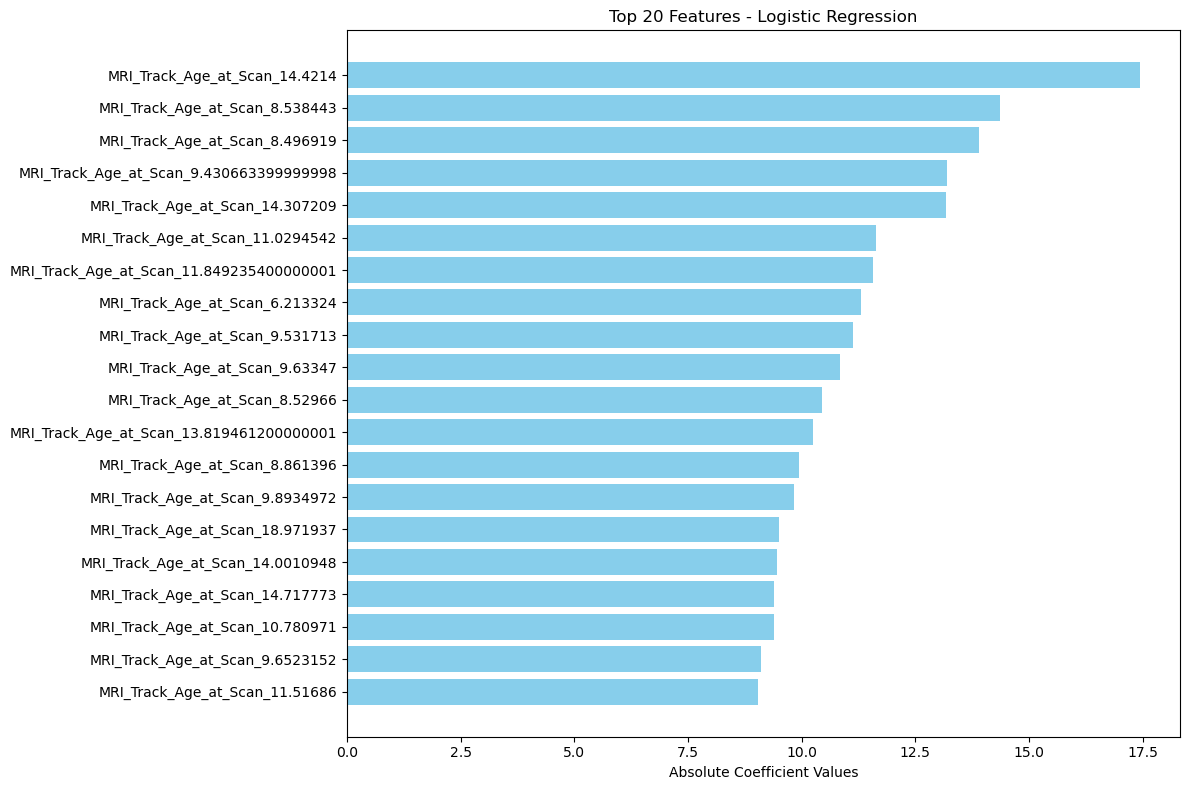

In [9]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS (supports Logistic Regression, LightGBM, XGBoost)
# =============================================================================

def analyze_feature_importance(best_model, best_model_name, feature_names):
    """
    Analyze and display feature importance for the best-performing model.

    Parameters:
    -----------
    best_model : sklearn or compatible model
        Trained model selected as best from testing phase.
        
    best_model_name : str
        Name of the best model (used to decide the method for importance extraction).
        
    feature_names : list of str
        Column names used during training, needed to label feature importances.

    Returns:
    --------
    importance_df : pandas.DataFrame
        Table containing 'Feature' and 'Importance' sorted from most to least important.
    """
    print(f"\nAnalyzing feature importance for {best_model_name}...")

    # =============================
    # Select feature importance method based on model type
    # =============================
    if best_model_name == 'Logistic Regression':
        # Use absolute logistic coefficients
        importance_values = np.abs(best_model.coef_[0])
        importance_type = "Absolute Coefficient Values"

    elif best_model_name == 'LightGBM':
        # LightGBM internal feature importance
        importance_values = best_model.feature_importances_
        importance_type = "Feature Importance (Split Gain)"

    elif best_model_name in ['XGBoost', 'XGBClassifier']:
        # XGBoost also provides feature_importances_
        importance_values = best_model.feature_importances_
        importance_type = "XGBoost Feature Importance"

    else:
        print("Feature importance not supported for this model type.")
        return None

    # Convert to DataFrame
    importance_df = (
        pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_values
        })
        .sort_values('Importance', ascending=False)
        .reset_index(drop=True)
    )

    # =============================
    # Display Top 10 Features
    # =============================
    print(f"\nTop 10 Most Important Features ({importance_type}):")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f" {i:2d}. {row['Feature']}: {row['Importance']:.4f}")

    # =============================
    # Visualization - Top 20
    # =============================
    top_20 = importance_df.head(20)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_20)), top_20['Importance'], color='skyblue')
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel(f'{importance_type}')
    plt.title(f'Top 20 Features - {best_model_name}')
    plt.gca().invert_yaxis()  # Show most important on top
    plt.tight_layout()
    plt.show()

    return importance_df


# Example usage
feature_importance_df = analyze_feature_importance(
    best_model,
    best_model_name,
    X_train.columns.tolist()
)


An AUC of 0.8 in predicting ADHD cases means the model can correctly rank an ADHD case above a non-ADHD case 80% of the time. From a healthcare perspective, this is strong evidence the model can be used as a screening tool — for example, to prioritize which children should be referred for full clinical diagnosis. This improves efficiency by reducing wasted clinical resources while also supporting earlier interventions for children who are truly at risk

    Final Test Set Results (Logistic Regression):
       Optimal threshold: 0.44
      • Macro F1-score: 0.7434
      • Macro Precision: 0.7482
      • Macro Recall: 0.7395
      • ROC AUC: 0.8455

   Class-specific Performance:
      • Class 0 (No ADHD):
         - Precision: 0.6667
         - Recall: 0.6250
      Class 1 (ADHD):
         - Precision: 0.8298
         - Recall: 0.8540


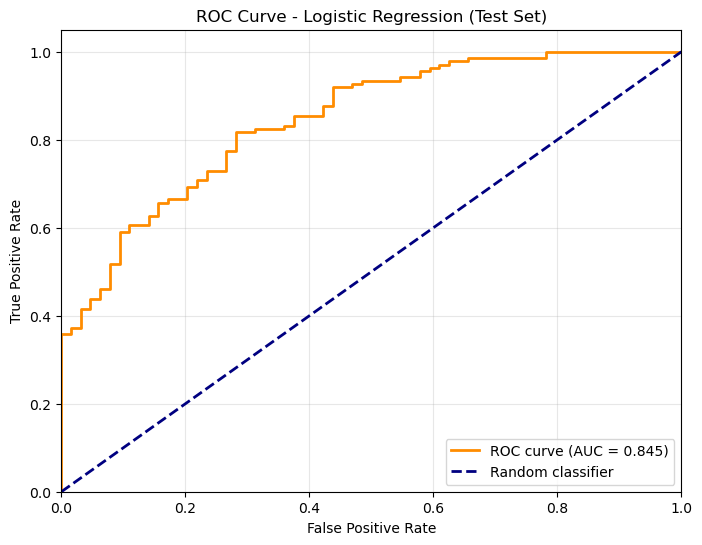

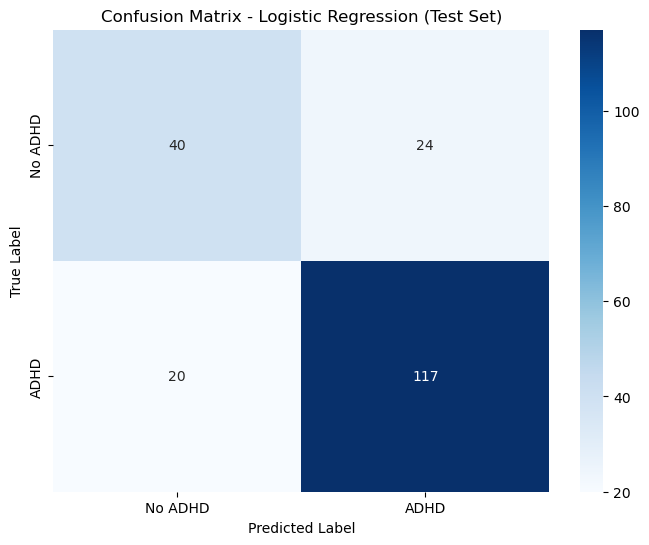

In [ ]:
# =============================================================================
# FINAL TEST SET EVALUATION
# =============================================================================

def evaluate_final_model(best_model, best_model_name, optimal_threshold, X_test, y_test):
    """
    Perform final evaluation on untouched test set.
    
    Parameters:
    -----------
    best_model : sklearn model
        Trained best model
    best_model_name : str
        Name of best model
    optimal_threshold : float
        Optimized classification threshold
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        Test target
    
    Returns:
    --------
    dict
        Final test results
    """
    
    
    # Make predictions on test set
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= 0.50).astype(int)
    
    # Calculate comprehensive metrics
    report = classification_report(y_test, y_test_pred, output_dict=True)
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    final_results = {
        'model_name': best_model_name,
        'f1_macro': report['macro avg']['f1-score'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'precision_0': report['0']['precision'],
        'precision_1': report['1']['precision'],
        'recall_0': report['0']['recall'],
        'recall_1': report['1']['recall'],
        'roc_auc': roc_auc
    }
    
    print(f"    Final Test Set Results ({best_model_name}):")

    print(f"      • Macro F1-score: {final_results['f1_macro']:.4f}")
    print(f"      • Macro Precision: {final_results['precision_macro']:.4f}")
    print(f"      • Macro Recall: {final_results['recall_macro']:.4f}")
    print(f"      • ROC AUC: {final_results['roc_auc']:.4f}")
    
    print(f"\n   Class-specific Performance:")
    print(f"      • Class 0 (No ADHD):")
    print(f"         - Precision: {final_results['precision_0']:.4f}")
    print(f"         - Recall: {final_results['recall_0']:.4f}")
    print(f"      Class 1 (ADHD):")
    print(f"         - Precision: {final_results['precision_1']:.4f}")
    print(f"         - Recall: {final_results['recall_1']:.4f}")
    
    # Create ROC curve
    create_roc_curve(fpr, tpr, roc_auc, best_model_name)
    
    # Create confusion matrix
    create_confusion_matrix(y_test, y_test_pred, best_model_name)
    
    return final_results

def create_roc_curve(fpr, tpr, roc_auc, model_name):
    """Create ROC curve visualization."""
    
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (Test Set)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

def create_confusion_matrix(y_true, y_pred, model_name):
    """Create confusion matrix visualization."""

    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No ADHD', 'ADHD'],
                yticklabels=['No ADHD', 'ADHD'])
    plt.title(f'Confusion Matrix - {model_name} (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Final evaluation
final_test_results = evaluate_final_model(
    best_model, best_model_name, optimal_threshold, X_test, y_test
)

In [22]:
# =============================================================================
# MODEL STABILITY ASSESSMENT
# =============================================================================

def assess_model_stability(best_model, 
                           X_train, y_train, X_val, y_val, 
                           X_test, y_test, n_seeds=5):
    """
    Assess model stability by retraining using different random seeds and
    checking how much performance varies.

    Why this is useful:
    -------------------
    A good model should produce similar performance even when trained with 
    slightly different random seeds. If the performance fluctuates a lot, 
    it may indicate instability or sensitivity to randomness in training.

    Parameters:
    -----------
    best_model : sklearn model
        Already optimized/trained model (e.g., best Logistic Regression).

    optimal_threshold : float
        Best threshold found for classification.

    X_train, y_train : Training data
    X_val, y_val     : Validation data (not used here but kept for consistency)
    X_test, y_test   : Test data for evaluating stability

    n_seeds : int
        Number of different random seeds to test.

    Returns:
    --------
    stability_df : pd.DataFrame
        Table containing performance metrics for each seed.
    """
    print("ASSESSING MODEL STABILITY")
    print("=" * 40)

    # Extract parameters from best_model to keep consistency
    best_params = best_model.get_params()

    # Remove parameters that should not be manually passed into new instances
    params_to_remove = ['random_state', 'n_jobs', 'verbose']
    for param in params_to_remove:
        best_params.pop(param, None)

    print(f" Testing {n_seeds} seeds with parameters: {best_params}")

    seeds = [21, 42, 100, 123, 2025][:n_seeds]
    stability_results = []

    for i, seed in enumerate(seeds, 1):
        print(f" - Training with seed {seed} ({i}/{n_seeds})")

        # Recreate model with the same parameters but different seed
        model_seed = LogisticRegression(random_state=seed, **best_params)

        # Train model
        model_seed.fit(X_train, y_train)

        # Predict on test set using optimal threshold
        y_test_proba = model_seed.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

        # Compute metrics
        report = classification_report(y_test, y_test_pred, output_dict=True)
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)

        stability_results.append({
            'seed': seed,
            'f1_macro': report['macro avg']['f1-score'],
            'precision_1': report['1']['precision'],
            'recall_1': report['1']['recall'],
            'auc': auc(fpr, tpr)
        })

    stability_df = pd.DataFrame(stability_results)

    # Summary statistics
    print("\nStability Results (Mean ± Std):")
    for metric in ['f1_macro', 'precision_1', 'recall_1', 'auc']:
        print(f" {metric:<15}: {stability_df[metric].mean():.4f} ± {stability_df[metric].std():.4f}")

    # Stability interpretation based on F1 variability
    f1_std = stability_df['f1_macro'].std()
    if f1_std < 0.01:
        stability_label = "Very Stable"
    elif f1_std < 0.02:
        stability_label = "Stable"
    elif f1_std < 0.05:
        stability_label = "Moderately Stable"
    else:
        stability_label = "Unstable"

    print(f"\nStability Assessment: {stability_label}")
    print(f"F1 Std Deviation: {f1_std:.4f}")

    return stability_df


# ✅ Correct function call
stability_df = assess_model_stability(
    best_model,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)


ASSESSING MODEL STABILITY
 Testing 5 seeds with parameters: {'C': 19.10178715209079, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001, 'warm_start': False}
 - Training with seed 21 (1/5)
 - Training with seed 42 (2/5)
 - Training with seed 100 (3/5)
 - Training with seed 123 (4/5)
 - Training with seed 2025 (5/5)

Stability Results (Mean ± Std):
 f1_macro       : 0.7350 ± 0.0032
 precision_1    : 0.8228 ± 0.0026
 recall_1       : 0.8540 ± 0.0000
 auc            : 0.8454 ± 0.0005

Stability Assessment: Very Stable
F1 Std Deviation: 0.0032


In [23]:
# =============================================================================
# MODEL DEPLOYMENT PREPARATION
# =============================================================================

def save_model(best_model, best_model_name, 
                            final_results, validation_results):
    """
    Save model and configuration files for deployment.
    
    Parameters:
    -----------
    best_model : sklearn model
        Trained best model
    best_model_name : str
        Name of best model
    optimal_threshold : float
        Optimal classification threshold
    final_results : dict
        Final test results
    validation_results : dict
        Validation results for all models
    """
   
    
    # Save the model
    model_filename = f'{best_model_name.lower().replace(" ", "_")}_model.joblib'
    joblib.dump(best_model, model_filename)
    print(f"  Model saved as: {model_filename}")
    

   
    
    # Save comprehensive model report
    model_report = {
        'model_info': {
            'name': best_model_name
            },
        'performance': {
            'test_f1_macro': final_results['f1_macro'],
            'test_roc_auc': final_results['roc_auc'],
            'test_precision_adhd': final_results['precision_1'],
            'test_recall_adhd': final_results['recall_1']
        },
        'model_comparison': {
            model: {
                'validation_f1_macro': results['f1_macro'],
                'validation_roc_auc': results['roc_auc']
            }
            for model, results in validation_results.items()
        },
        'stability': {
            'mean_f1_macro': stability_df['f1_macro'].mean(),
            'std_f1_macro': stability_df['f1_macro'].std(),
            'mean_auc': stability_df['auc'].mean(),
            'std_auc': stability_df['auc'].std()
        }
    }
    
    with open('adhd_model_report.json', 'w') as f:
        json.dump(model_report, f, indent=2)
    print(f"  Model report saved as: adhd_model_report.json")
    
 
    print(f"    Model: {best_model_name}")
    print(f"    Test F1-Macro: {final_results['f1_macro']:.4f}")
    print(f"     AUC: {final_results['roc_auc']:.3f}")

# Save deployment artifacts
save_model(
    best_model, best_model_name, 
    final_test_results, validation_results
)

  Model saved as: logistic_regression_model.joblib
  Model report saved as: adhd_model_report.json
    Model: Logistic Regression
    Test F1-Macro: 0.7434
     AUC: 0.845
